In [1]:
# Impport necessary libraries
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import json
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

In [2]:
# Only include access points from the first floor (prefix-based)
ALLOWED_PREFIXES = {
    '70:b3:17:8d:e9',
    '70:b3:17:8e:1c',
    '78:bc:1a:37:7e',
    '48:8b:0a:ca:a8',
    '48:8b:0a:cb:67',
    '48:8b:0a:cb:69'
}

In [3]:
# Function to read fingerprint data and return it as a dictionary
def read_fingerprint_data(file_path):
    fingerprint_data = {}
    fpData = pd.read_csv(file_path)
    for index, row in fpData.iterrows():
        key = str(row['PosX']) + "_" + str(row['PosY'])
        RSSI = int(row['RSSI'])
        if key in fingerprint_data:
            fingerprint_data[key][row['BSSID']] = RSSI
        else:
            fingerprint_data[key] = {row['BSSID']: RSSI}
    return fingerprint_data

In [4]:
def fingerprint_to_dataframe(fingerprint_data):
    rows = []
    for key, rssi_dict in fingerprint_data.items():
        x, y = map(int, key.split('_'))
        filtered_rssi = {bssid: rssi for bssid, rssi in rssi_dict.items() if bssid[:14] in ALLOWED_PREFIXES}
        row = {'x': x, 'y': y}
        row.update(filtered_rssi)
        rows.append(row)
    df = pd.DataFrame(rows)
    df.fillna(-100, inplace=True)
    return df


In [5]:
# Load and preprocess data
fp_dict = read_fingerprint_data('fpData-Full.txt')
df = fingerprint_to_dataframe(fp_dict)

In [6]:
df.head()

,x,y,48:8b:0a:ca:a8:0d,48:8b:0a:ca:a8:0b,48:8b:0a:ca:a8:0c,48:8b:0a:ca:a8:0e,48:8b:0a:ca:a8:0f,48:8b:0a:ca:a8:02,48:8b:0a:ca:a8:03,48:8b:0a:ca:a8:01,...,70:b3:17:8d:e9:63,70:b3:17:8d:e9:61,70:b3:17:8d:e9:60,70:b3:17:8d:e9:62,48:8b:0a:ca:a8:04,48:8b:0a:ca:a8:00,78:bc:1a:37:7e:00,48:8b:0a:cb:69:20,70:b3:17:8d:e9:64,48:8b:0a:cb:69:24
0,1286,858,-37.0,-37.0,-37.0,-38.0,-38.0,-50.0,-50.0,-50.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
1,526,1111,-87.0,-87.0,-87.0,-86.0,-87.0,-100.0,-100.0,-100.0,...,-75.0,-75.0,-75.0,-75.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
2,793,371,-73.0,-73.0,-73.0,-73.0,-73.0,-100.0,-100.0,-100.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
3,1220,912,-45.0,-45.0,-45.0,-45.0,-41.0,-51.0,-51.0,-52.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0
4,1256,912,-45.0,-45.0,-45.0,-45.0,-41.0,-49.0,-49.0,-49.0,...,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0,-100.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 62 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   x                  1131 non-null   int64  
 1   y                  1131 non-null   int64  
 2   48:8b:0a:ca:a8:0d  1131 non-null   float64
 3   48:8b:0a:ca:a8:0b  1131 non-null   float64
 4   48:8b:0a:ca:a8:0c  1131 non-null   float64
 5   48:8b:0a:ca:a8:0e  1131 non-null   float64
 6   48:8b:0a:ca:a8:0f  1131 non-null   float64
 7   48:8b:0a:ca:a8:02  1131 non-null   float64
 8   48:8b:0a:ca:a8:03  1131 non-null   float64
 9   48:8b:0a:ca:a8:01  1131 non-null   float64
 10  78:bc:1a:37:7e:0f  1131 non-null   float64
 11  78:bc:1a:37:7e:0b  1131 non-null   float64
 12  78:bc:1a:37:7e:0e  1131 non-null   float64
 13  78:bc:1a:37:7e:0c  1131 non-null   float64
 14  78:bc:1a:37:7e:0d  1131 non-null   float64
 15  78:bc:1a:37:7e:02  1131 non-null   float64
 16  78:bc:1a:37:7e:03  1131 

In [8]:
bssid_columns = df.columns[2:]  # Skip 'x' and 'y'
prefixes = [bssid[:14] for bssid in bssid_columns]  # First 14 characters = first 5 octets
unique_prefixes = set(prefixes)
print(f"Unique BSSID prefixes (likely AP count): {len(unique_prefixes)}")


Unique BSSID prefixes (likely AP count): 6


In [9]:
bssid_columns

Index(['48:8b:0a:ca:a8:0d', '48:8b:0a:ca:a8:0b', '48:8b:0a:ca:a8:0c',
       '48:8b:0a:ca:a8:0e', '48:8b:0a:ca:a8:0f', '48:8b:0a:ca:a8:02',
       '48:8b:0a:ca:a8:03', '48:8b:0a:ca:a8:01', '78:bc:1a:37:7e:0f',
       '78:bc:1a:37:7e:0b', '78:bc:1a:37:7e:0e', '78:bc:1a:37:7e:0c',
       '78:bc:1a:37:7e:0d', '78:bc:1a:37:7e:02', '78:bc:1a:37:7e:03',
       '78:bc:1a:37:7e:01', '78:bc:1a:37:7e:04', '48:8b:0a:cb:69:2f',
       '48:8b:0a:cb:69:2b', '48:8b:0a:cb:69:21', '48:8b:0a:cb:69:2e',
       '48:8b:0a:cb:67:ed', '48:8b:0a:cb:67:ef', '48:8b:0a:cb:67:ee',
       '48:8b:0a:cb:69:2c', '48:8b:0a:cb:67:eb', '48:8b:0a:cb:67:ec',
       '48:8b:0a:cb:69:2d', '48:8b:0a:cb:69:22', '48:8b:0a:cb:67:e3',
       '48:8b:0a:cb:67:e2', '48:8b:0a:cb:67:e4', '48:8b:0a:cb:67:e1',
       '48:8b:0a:cb:67:e0', '48:8b:0a:cb:69:23', '70:b3:17:8e:1c:0c',
       '70:b3:17:8e:1c:0b', '70:b3:17:8e:1c:0d', '70:b3:17:8e:1c:0e',
       '70:b3:17:8e:1c:0f', '70:b3:17:8e:1c:03', '70:b3:17:8e:1c:02',
       '70:b3:17:8e:

In [10]:
unique_prefixes

{'48:8b:0a:ca:a8',
 '48:8b:0a:cb:67',
 '48:8b:0a:cb:69',
 '70:b3:17:8d:e9',
 '70:b3:17:8e:1c',
 '78:bc:1a:37:7e'}

In [11]:
grouped_df = df.copy()
group_map = {}

for bssid in bssid_columns:
    prefix = bssid[:14]
    if prefix not in group_map:
        group_map[prefix] = []
    group_map[prefix].append(bssid)

# Aggregate by max RSSI per group (as an example)
for prefix, group in group_map.items():
    grouped_df[prefix] = df[group].max(axis=1)

# Drop original full BSSID columns
grouped_df = grouped_df.drop(columns=bssid_columns)


In [12]:
grouped_df.head()

,x,y,48:8b:0a:ca:a8,78:bc:1a:37:7e,48:8b:0a:cb:69,48:8b:0a:cb:67,70:b3:17:8e:1c,70:b3:17:8d:e9
0,1286,858,-37.0,-66.0,-79.0,-80.0,-87.0,-100.0
1,526,1111,-86.0,-85.0,-100.0,-82.0,-38.0,-73.0
2,793,371,-73.0,-87.0,-82.0,-40.0,-74.0,-100.0
3,1220,912,-41.0,-56.0,-89.0,-91.0,-80.0,-100.0
4,1256,912,-41.0,-56.0,-89.0,-91.0,-84.0,-100.0


In [13]:
grouped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1131 entries, 0 to 1130
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   x               1131 non-null   int64  
 1   y               1131 non-null   int64  
 2   48:8b:0a:ca:a8  1131 non-null   float64
 3   78:bc:1a:37:7e  1131 non-null   float64
 4   48:8b:0a:cb:69  1131 non-null   float64
 5   48:8b:0a:cb:67  1131 non-null   float64
 6   70:b3:17:8e:1c  1131 non-null   float64
 7   70:b3:17:8d:e9  1131 non-null   float64
dtypes: float64(6), int64(2)
memory usage: 70.8 KB


In [14]:
# Normalize features
# Standardizing; making each feature (column) have Mean = 0 and Standard Deviation = 1.
features = grouped_df.drop(columns=['x', 'y'])
scaler = StandardScaler()
normalized_features = scaler.fit_transform(features)

In [15]:
# Split into training and test sets
X_train, X_test = train_test_split(normalized_features, test_size=0.1, random_state=42)

In [33]:
results = []
k_range = range(2, 21)

In [34]:
# K-Means will try to find each cluster's center and assign each RP to the closest cluster.

In [35]:
# --- KMeans ---
best_k = 2
best_score = -1
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_labels = kmeans.fit_predict(X_train)
    score = silhouette_score(X_train, kmeans_labels)
    if score > best_score:
        best_k = k
        best_score = score
start = time.time()
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X_train)
end = time.time()
kmeans_labels = kmeans.labels_
results.append({
    'Algorithm': 'KMeans',
    'Best_k': best_k,
    'Clustering Time (s)': round(end - start, 4),
    'Silhouette Score': round(silhouette_score(X_train, kmeans_labels), 4)
})

C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

In [36]:
kmeans_labels

array([4, 7, 7, ..., 6, 3, 6], dtype=int32)

In [37]:
kmeans.cluster_centers_

array([[ 1.76698031e+00,  7.17307232e-01,  5.67288522e-01,
        -2.55233621e-01, -4.79238877e-01, -6.53513189e-01],
       [ 1.53612083e-03, -8.72005452e-03, -4.56912380e-01,
         5.41822563e-01,  9.59494612e-01,  4.47796080e-01],
       [-4.15440441e-01, -1.03585111e+00,  2.45553556e+00,
        -4.52700591e-01, -1.65655207e+00, -6.76997554e-01],
       [ 5.85005670e-01,  1.51812106e+00, -4.98448612e-01,
        -1.29650885e+00, -7.92541683e-01, -6.76997554e-01],
       [-1.13447273e+00, -6.36851423e-01, -9.19423202e-01,
        -6.54637599e-01,  1.57589040e+00,  2.14112624e+00],
       [-4.27258902e-01, -7.90869514e-01,  5.17196670e-01,
         1.68793833e+00, -2.71023223e-01, -6.40239418e-01],
       [-1.13554505e+00, -1.06608915e+00, -6.70545066e-01,
         3.70794313e-01, -2.06971623e-02,  4.65908205e-01],
       [ 3.21055952e-01,  1.05856600e+00, -6.82758778e-01,
        -5.45260115e-01,  4.11303739e-01, -2.53751247e-01]])

In [38]:
len(kmeans.cluster_centers_)

8

In [39]:
len(kmeans.cluster_centers_[0])

6

In [40]:
len(kmeans.cluster_centers_[1])

6

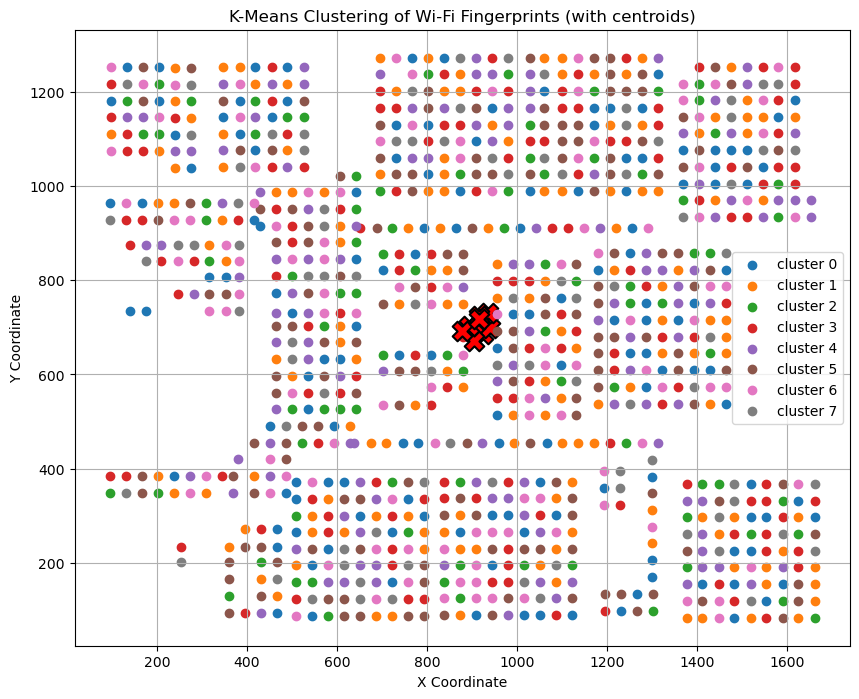

In [41]:
df_train = df.iloc[:len(X_train)].copy()
df_train['label'] = kmeans_labels
centroid_positions = df_train.groupby('label')[['x', 'y']].mean().values


plt.figure(figsize=(10, 8))
for label in sorted(df_train['label'].unique()):
    cluster_points = df_train[df_train['label'] == label]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=f'cluster {label}')
    plt.scatter(
        centroid_positions[label][0], 
        centroid_positions[label][1],
        marker='X', 
        s=200, 
        edgecolors='black', 
        linewidths=1.5, 
        c='red'
    )

plt.legend()
plt.title("K-Means Clustering of Wi-Fi Fingerprints (with centroids)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.show()

In [42]:
# Create a labeled DataFrame from clustering results
df_train = df.iloc[:len(X_train)].copy()
df_train['label'] = kmeans_labels

# Calculate visual centroids
centroid_positions = df_train.groupby('label')[['x', 'y']].mean().values


img = cv2.imread('images/HV I-J Plan 1.png')
output_img = img.copy()

# Color palette for clusters
colors = [
    (255, 0, 0),    # Blue
    (0, 255, 0),    # Green
    (0, 0, 255),    # Red
    (255, 255, 0),  # Cyan
    (255, 0, 255),  # Magenta
    (0, 255, 255),  # Yellow
    (128, 0, 128),  # Purple
    (0, 128, 255),  # Orange
    (128, 128, 128) # Gray
]

# Draw points and centroids
for label in sorted(df_train['label'].unique()):
    cluster_points = df_train[df_train['label'] == label]
    color = colors[label % len(colors)]

    for _, row in cluster_points.iterrows():
        x, y = int(row['x']), int(row['y'])
        cv2.circle(output_img, (x, y), radius=4, color=color, thickness=-1)

    # Draw centroid
    cx = int(centroid_positions[label][0])
    cy = int(centroid_positions[label][1])
    cv2.circle(output_img, (cx, cy), 8, (0, 0, 0), 2)  # black edge
    cv2.circle(output_img, (cx, cy), 6, (0, 0, 255), -1)  # red center

# Show the final image
cv2.imshow("K-Means Clusters on Floor Plan", output_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# save it
cv2.imwrite("images/k-means_clustered_floorplan.png", output_img)

True

In [43]:
# To determin the number of clusters in GMM, we can try to find the model that minimizes a theoretical information criterion,
# such as the Bayesian information criterion

In [44]:
# --- GMM ---
best_k, lowest_bic = 2, np.inf
for k in k_range:
    gmm = GaussianMixture(n_components=k, covariance_type='diag', reg_covar=1e-3, random_state=42)
    gmm.fit(X_train)
    bic = gmm.bic(X_train)
    if bic < lowest_bic:
        best_k, lowest_bic = k, bic
start = time.time()
gmm = GaussianMixture(n_components=best_k, covariance_type='diag', reg_covar=1e-3, random_state=42).fit(X_train)
end = time.time()
gmm_labels = gmm.predict(X_train)
silhouette = silhouette_score(X_train, gmm_labels) if len(set(gmm_labels)) > 1 else -1.0
results.append({
    'Algorithm': 'GMM',
    'Best_k': best_k,
    'Clustering time (s)': round(end - start, 4),
    'Silhouette Score': np.float64(round(silhouette, 4))
})

C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\Users\saleh\Anaconda3\envs\ml_env\lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning:

In [45]:
gmm_labels

array([ 8,  1,  1, ..., 15,  9, 15])

In [46]:
len(gmm_labels)

1017

In [47]:
best_k

19

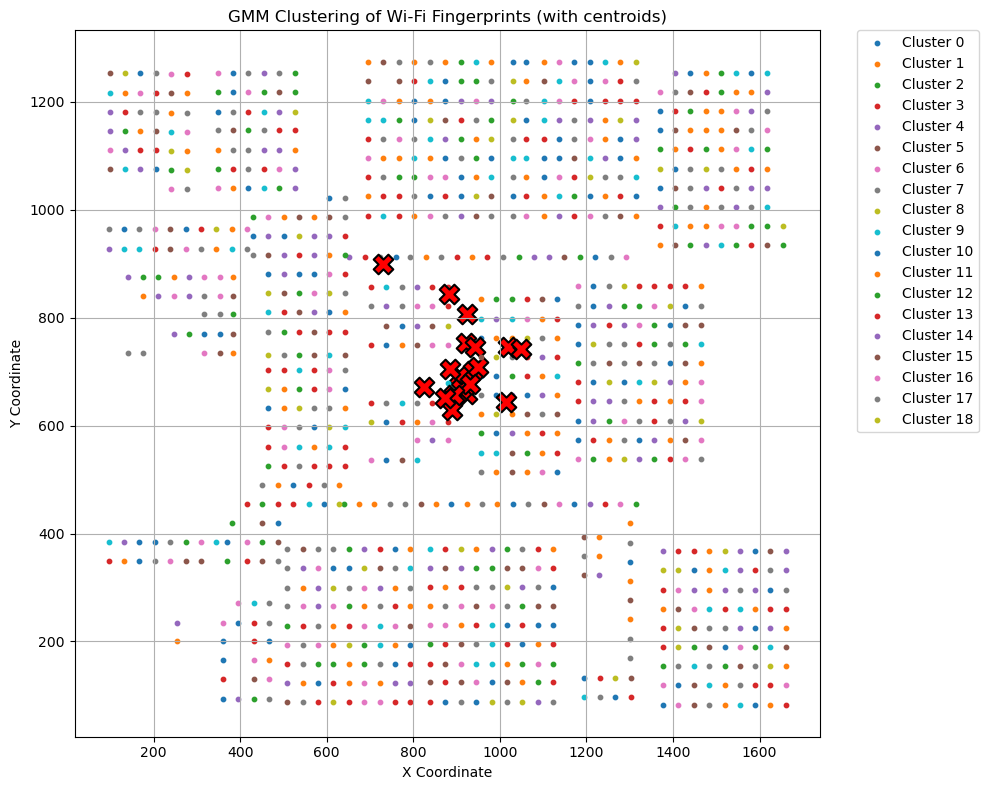

In [48]:
df_train = df.iloc[:len(X_train)].copy()
df_train['label'] = gmm_labels  # Use GMM labels

# Calculate centroids of each GMM cluster (mean x and y)
centroid_positions = df_train.groupby('label')[['x', 'y']].mean().values

# Plotting
plt.figure(figsize=(10, 8))
for label in sorted(df_train['label'].unique()):
    cluster_points = df_train[df_train['label'] == label]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {label}', s=10)
    plt.scatter(
        centroid_positions[label][0],
        centroid_positions[label][1],
        marker='X',
        s=200,
        edgecolors='black',
        linewidths=1.5,
        c='red'
    )

plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title("GMM Clustering of Wi-Fi Fingerprints (with centroids)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.tight_layout()
plt.show()


In [50]:
# --- Visualization ---
import os
# Create labeled DataFrame from GMM results
df_train = df.iloc[:len(X_train)].copy()
df_train['label'] = gmm_labels

# Calculate visual centroids
centroid_positions = df_train.groupby('label')[['x', 'y']].mean().values

# Load and copy floorplan image
img = cv2.imread('images/HV I-J Plan 1.png')
output_img = img.copy()

# Extended color palette for 36 clusters (generate distinct colors using HSV)
colors = [
    tuple(int(c) for c in cv2.cvtColor(np.uint8([[[i * 7, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0])
    for i in range(best_k)
]

# Draw points and centroids
for label in sorted(df_train['label'].unique()):
    cluster_points = df_train[df_train['label'] == label]
    color = colors[label % len(colors)]

    for _, row in cluster_points.iterrows():
        x, y = int(row['x']), int(row['y'])
        cv2.circle(output_img, (x, y), radius=3, color=color, thickness=-1)

    # Draw centroid
    cx = int(centroid_positions[label][0])
    cy = int(centroid_positions[label][1])
    cv2.circle(output_img, (cx, cy), 6, (0, 0, 0), 2)  # black edge
    cv2.circle(output_img, (cx, cy), 4, (0, 0, 255), -1)  # red center

# Save image
os.makedirs("images", exist_ok=True)
cv2.imwrite("images/gmm_clustered_floorplan_36.png", output_img)

#  display
cv2.imshow("GMM Clusters on Floor Plan", output_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [51]:
# --- Agglomerative Clustering ---
best_k = 2
best_score = -1
for k in k_range:
    agglomerative = AgglomerativeClustering(n_clusters=k)
    agglomerative_labels = agglomerative.fit_predict(X_train)
    score = silhouette_score(X_train, agglomerative_labels)
    if score > best_score:
        best_k = k
        best_score = score
start = time.time()
agglomerative = AgglomerativeClustering(n_clusters=best_k).fit(X_train)
end = time.time()
agglomerative_labels = agglomerative.labels_
results.append({
    'Algorithm': 'Agglomerative',
    'Best_k': best_k,
    'Clustering Time (s)': round(end - start, 4),
    'Silhouette Score': round(silhouette_score(X_train, agglomerative_labels), 4)
})

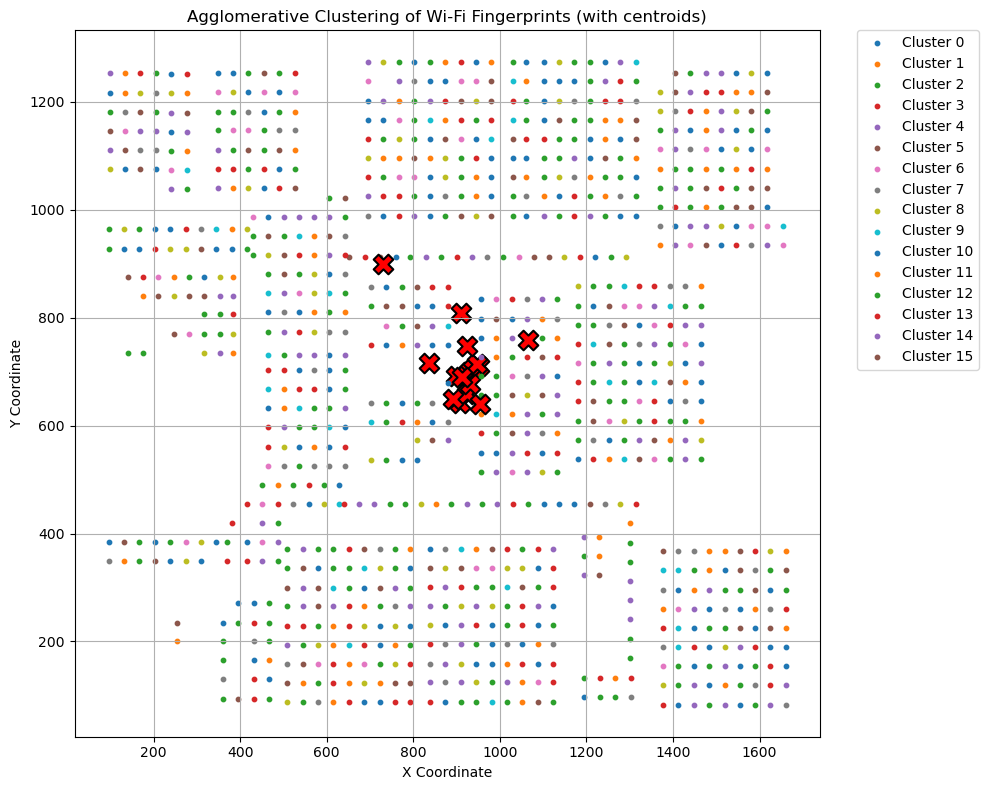

In [52]:
# Use Agglomerative labels instead of GMM
df_train = df.iloc[:len(X_train)].copy()
df_train['label'] = agglomerative_labels  # Use Agglomerative labels

# Calculate centroids of each Agglomerative cluster (mean x and y)
centroid_positions = df_train.groupby('label')[['x', 'y']].mean().values

# Plotting
plt.figure(figsize=(10, 8))
for label in sorted(df_train['label'].unique()):
    cluster_points = df_train[df_train['label'] == label]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {label}', s=10)
    plt.scatter(
        centroid_positions[label][0],
        centroid_positions[label][1],
        marker='X',
        s=200,
        edgecolors='black',
        linewidths=1.5,
        c='red'
    )

plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title("Agglomerative Clustering of Wi-Fi Fingerprints (with centroids)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.tight_layout()
plt.show()


In [53]:
import os

# --- Visualization for Agglomerative Clustering ---
# Create labeled DataFrame from Agglomerative Clustering results
df_train = df.iloc[:len(X_train)].copy()
df_train['label'] = agglomerative_labels

# Calculate visual centroids
centroid_positions = df_train.groupby('label')[['x', 'y']].mean().values

# Load and copy floorplan image
img = cv2.imread('images/HV I-J Plan 1.png')
output_img = img.copy()

# Extended color palette for clusters (generate distinct colors using HSV)
colors = [
    tuple(int(c) for c in cv2.cvtColor(np.uint8([[[i * 7, 255, 255]]]), cv2.COLOR_HSV2BGR)[0][0])
    for i in range(best_k)
]

# Draw points and centroids
for label in sorted(df_train['label'].unique()):
    cluster_points = df_train[df_train['label'] == label]
    color = colors[label % len(colors)]

    for _, row in cluster_points.iterrows():
        x, y = int(row['x']), int(row['y'])
        cv2.circle(output_img, (x, y), radius=3, color=color, thickness=-1)

    # Draw centroid
    cx = int(centroid_positions[label][0])
    cy = int(centroid_positions[label][1])
    cv2.circle(output_img, (cx, cy), 6, (0, 0, 0), 2)  # black edge
    cv2.circle(output_img, (cx, cy), 4, (0, 0, 255), -1)  # red center

# Save image
os.makedirs("images", exist_ok=True)
cv2.imwrite("images/agglomerative_clustered_floorplan.png", output_img)

# Display
cv2.imshow("Agglomerative Clusters on Floor Plan", output_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [65]:
# --- DBSCAN with PCA + tuning ---
from sklearn.decomposition import PCA

use_pca = True
X_dbscan = PCA(n_components=5).fit_transform(X_train) if use_pca else X_train

eps_values = [0.8, 1.0, 1.2, 1.6, 2.0, 2.5, 3.0]
best_silhouette = -1.0
best_result = {}
best_model = None

for eps in eps_values:
    start = time.time()
    dbscan = DBSCAN(eps=eps, min_samples=4).fit(X_dbscan)
    end = time.time()
    labels = dbscan.labels_
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        silhouette = round(silhouette_score(X_dbscan, labels), 4)
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_result = {
                'Algorithm': 'DBSCAN',
                'Best_k': n_clusters,
                'Clustering Time (s)': round(end - start, 4),
                'Silhouette Score': np.float64(silhouette)
            }
            best_labels = labels
            best_model = dbscan

if best_result:
    results.append(best_result)
else:
    results.append({
        'Algorithm': 'DBSCAN',
        'Best_k': 1,
        'Clustering Time (s)': 0,
        'Silhouette Score': -1
    })


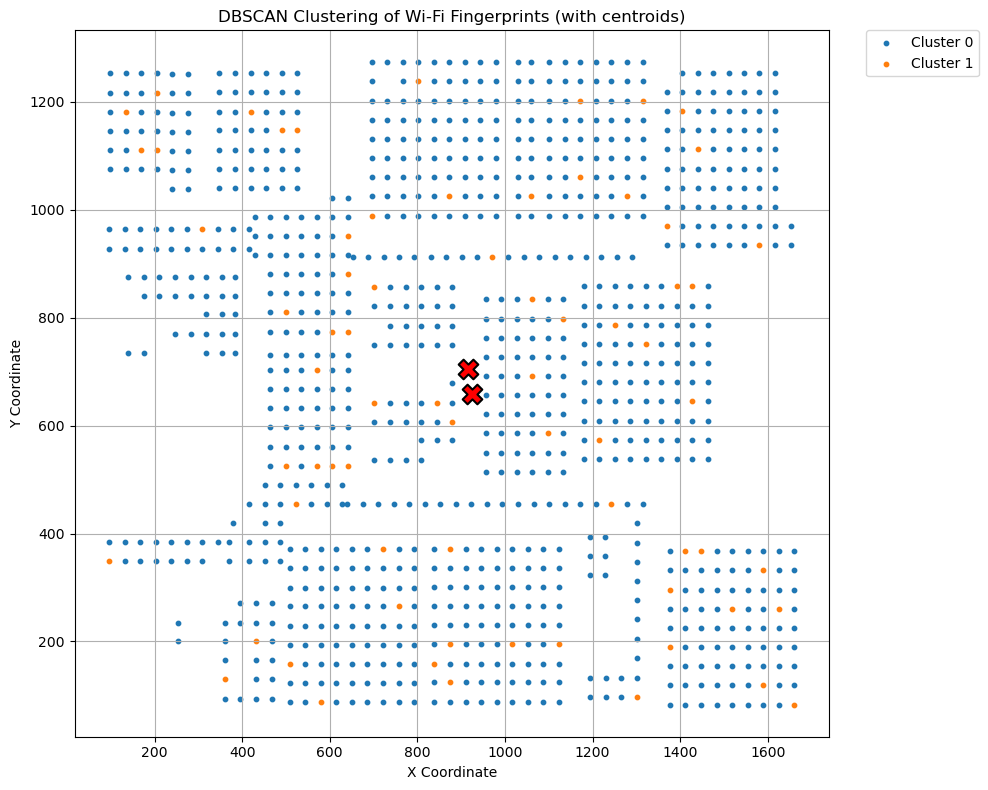

In [66]:
# --- Visualization using matplotlib for DBSCAN ---
df_train = df.iloc[:len(X_train)].copy()
df_train['label'] = best_labels

# Filter out noise (-1 label)
valid_clusters = df_train[df_train['label'] != -1]
centroid_positions = valid_clusters.groupby('label')[['x', 'y']].mean().values

plt.figure(figsize=(10, 8))
for label in sorted(valid_clusters['label'].unique()):
    cluster_points = valid_clusters[valid_clusters['label'] == label]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=f'Cluster {label}', s=10)
    plt.scatter(
        centroid_positions[label][0],
        centroid_positions[label][1],
        marker='X',
        s=200,
        edgecolors='black',
        linewidths=1.5,
        c='red'
    )

# Optional: plot noise points
noise_points = df_train[df_train['label'] == -1]
if not noise_points.empty:
    plt.scatter(noise_points['x'], noise_points['y'], c='gray', s=10, label='Noise')

plt.legend(loc='best', bbox_to_anchor=(1.05, 1), borderaxespad=0.)
plt.title("DBSCAN Clustering of Wi-Fi Fingerprints (with centroids)")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.tight_layout()
plt.show()


In [69]:
# --- Visualization using OpenCV for DBSCAN ---
df_train = df.iloc[:len(X_train)].copy()
df_train['label'] = best_labels

# Filter out noise
valid_clusters = df_train[df_train['label'] != -1]
unique_labels = sorted(valid_clusters['label'].unique())  # actual cluster labels
centroid_positions = valid_clusters.groupby('label')[['x', 'y']].mean().to_dict('index')

# Load floorplan
img = cv2.imread('images/HV I-J Plan 1.png')
output_img = img.copy()

# Generate distinct HSV colors
# Manually define highly distinct BGR colors
distinct_bgr_colors = [
    (255, 0, 0),     # Blue
    (0, 255, 0),     # Green
    (0, 0, 255),     # Red
    (255, 255, 0),   # Cyan
    (255, 0, 255),   # Magenta
    (0, 255, 255),   # Yellow
    (128, 0, 128),   # Purple
    (0, 128, 255),   # Orange-ish
    (0, 0, 128),     # Dark red
    (0, 128, 0),     # Dark green
]

# Map actual DBSCAN labels to distinct colors
colors = {
    label: distinct_bgr_colors[i % len(distinct_bgr_colors)]
    for i, label in enumerate(unique_labels)
}


# Draw points and centroids
for label in unique_labels:
    cluster_points = valid_clusters[valid_clusters['label'] == label]
    color = colors[label]

    for _, row in cluster_points.iterrows():
        x, y = int(row['x']), int(row['y'])
        cv2.circle(output_img, (x, y), radius=3, color=color, thickness=-1)

    # Centroid
    cx = int(centroid_positions[label]['x'])
    cy = int(centroid_positions[label]['y'])
    cv2.circle(output_img, (cx, cy), 6, (0, 0, 0), 2)
    cv2.circle(output_img, (cx, cy), 4, (0, 0, 255), -1)

# Draw noise in gray
noise_points = df_train[df_train['label'] == -1]
for _, row in noise_points.iterrows():
    x, y = int(row['x']), int(row['y'])
    cv2.circle(output_img, (x, y), radius=2, color=(160, 160, 160), thickness=-1)

# Save and show image
os.makedirs("images", exist_ok=True)
cv2.imwrite("images/dbscan_clustered_floorplan.png", output_img)

cv2.imshow("DBSCAN Clusters on Floor Plan", output_img)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [56]:
# The labels of all the instances are available in the labels_ instance variable
# instances that have cluster index -1 are considered as nomalies
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0])

In [57]:
len(dbscan.labels_)

1017

In [58]:
# The indices of the core instances are avaliable in the core_saple_indices_ instance variable
# , and the core instances themselves are available in the components_instance variable
len(dbscan.core_sample_indices_)

1017

In [59]:
dbscan.core_sample_indices_

array([   0,    1,    2, ..., 1014, 1015, 1016])

In [60]:
dbscan.components_

array([[ 3.62874902,  0.53117227, -1.67142337,  0.70687301,  0.53379397],
       [ 0.09864685,  1.60057074, -0.01317793, -0.24353849,  0.05348814],
       [-0.64523669,  1.47495631,  0.13831976, -0.76555144, -0.20159858],
       ...,
       [ 1.78905257, -0.53372247, -0.81621073, -0.56607364,  0.83918002],
       [-1.42539543,  1.24536519, -1.21155603, -0.39468175, -0.42245704],
       [ 1.4167683 , -0.16805474, -0.56786306, -0.84413686,  0.16899858]])

In [61]:
len(dbscan.components_)

1017

In [ ]:
# Save results
with open('clustering_accuracy_metrics.json', 'w') as f:
    json.dump(results, f, indent=2)

In [62]:
# Print results
for r in results:
    print(r)

{'Algorithm': 'KMeans', 'Best_k': 8, 'Clustering Time (s)': 0.0647, 'Silhouette Score': np.float64(0.4385)}
{'Algorithm': 'GMM', 'Best_k': 19, 'Clustering time (s)': 0.044, 'Silhouette Score': np.float64(0.4094)}
{'Algorithm': 'Agglomerative', 'Best_k': 16, 'Clustering Time (s)': 0.035, 'Silhouette Score': np.float64(0.4238)}
{'Algorithm': 'DBSCAN', 'Best_k': 2, 'Clustering Time (s)': 0.018, 'Silhouette Score': np.float64(0.3314)}
